# Tangelo hands-on: hardware experiments

## Before you jump in

This hands-on notebook complements existing tutorials, documentation and the developer notes available in the Tangelo GitHub repositories, which present content in much more depth.

You will come across code cells that require you to change code or fill in the blanks in order to achieve a desired outcome. There may be many ways to solve these simple exercises, and you are encouraged to explore.

----

**Getting started**

Please have a look at the landing page of this repository for guidance about how to deploy these notebooks and get started easily.

In order to complete this hands-on tutorial, we recommend you use the latest version of Tangelo.
If you encounter errors related to missing Python packages (classical chemistry backend, quantum circuit simulator...), you can install them on-the-fly by typing `!pip install <package-name>` in a new code cell, and then restart the Jupyter notebook kernel.

In [1]:
# If Tangelo is not found in your current environment, this cell installs all dependencies required for this hands-on
try:
    import tangelo
except ModuleNotFoundError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop  --quiet
    !pip install qulacs qiskit qiskit-ibm-runtime qiskit-aer amazon-braket-sdk --quiet
    !pip install pyscf --quiet

----

For this hands-on, we recommend you consider the following resources:
- Optional: For connecting to quantum devices, have a look at this [tutorial notebook](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/examples/workflow_basics/2.qpu_connection.ipynb).
- Optional: [A Tangelo post released on AWS Quantum Blog](https://aws.amazon.com/blogs/quantum-computing/exploring-quantum-chemistry-applications-with-tangelo-and-qemist-cloud-using-amazon-braket/) exploring the Umbrella inversion on molecules such as $H_3O^+$ and $NH_3$ in `cc-pvdz` basis.
- Optional: [Any tutorial](https://github.com/goodchemistryco/Tangelo-Examples/blob/main/contents.rst) tagged ![](https://img.shields.io/badge/-Experiment-7373e3). Some of them have fully detailed accounts of hardware experiments that resulted in published work.

----

## Hands-on

### 1. Connecting to a quantum device

No experiment on quantum hardware would be possible without the ability to send a task to a quantum device. It is very straightforward with the connection objects in Tangelo. Let's define a simple circuit as a use case:



findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


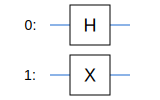

In [2]:
from tangelo.linq import Gate, Circuit

c = Circuit([Gate('H', 0), Gate('X', 1)])
c.draw()

**Example: IBM Quantum**

If you have an account with [IBM Quantum](https://quantum-computing.ibm.com/login), you can log in and retrieve your API token in order to run the cell below. You should see the task pop up in your IBM Quantum dashboard. You just submitted an experiment on IBM Quantum using Tangelo !

Submitting a task to an actual quantum device may take a long time, as your job will likely be queued. The cell below uses the `ibmq_qasm_simulator` backend, which should be available right away and fast.

In [ ]:
from tangelo.linq.qpu_connection import IBMConnection

conn = IBMConnection(ibm_quantum_token='')
job_id = conn.job_submit('sampler', 'ibmq_qasm_simulator', 10**5, c)
job_results = conn.job_results(job_id)

print(f"Simulation results from IBM Quantum : {job_results}")

### 2. A "simple experiment"

Remember VQE ? It is a NISQ algorithm that uses relatively shallow parameterized circuits and the variational principle to compute the energy of a molecule, as an expectation value. For this use case, let's apply it to a simple $H_2$ molecule to generate a qubit Hamiltonian and a quantum circuit with optimized variational parameters.

The optimized VQE energy is the expectation of the qubit Hamiltonian of the system, with regards to the state preparation define by the optimized circuit.

In [3]:
from tangelo import SecondQuantizedMolecule
from tangelo.algorithms import VQESolver

# Define H2 molecule
xyz_H2 = [("H", (0., 0., 0.)), ("H", (0., 0., 0.7414))]
mol_H2_sto3g = SecondQuantizedMolecule(xyz_H2, q=0, spin=0, basis="sto-3g")
mol = mol_H2_sto3g

# Run VQE
vqe_options = {"molecule": mol, "qubit_mapping": 'jw'}
vqe_solver = VQESolver(vqe_options)
vqe_solver.build()
opt_energy = vqe_solver.simulate()
print(opt_energy)

# Retrieve optimal circuit and qubit Hamiltonian
c = vqe_solver.optimal_circuit
qb_ham = vqe_solver.qubit_hamiltonian

-1.1372701683419155


/home/valentin/Desktop/virtualenvs/qce23/lib/python3.8/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


### Quantum circuit simplification

Operations on current quantum devices are not carried with 100% fidelity: noise accumulates as the device executes the quantum circuit. As a result, it is desirable to compile circuits that are as efficient and shallow as possible for the target device.

As it turns out, the circuit returned by VQE features a number of operations that can be discarded or simplified. For instance, `RZ` gates with an angle very close to 0 will be very close to the identity, and could be discarded (for instance, some of current quantum devices can only perform rotation gates with an accuracy of about `0.001` on the angle, and would therefore treat a smaller value as a 0).

> **Q**: Take a look at the [Circuit class methods](https://github.com/goodchemistryco/Tangelo/blob/main/tangelo/linq/circuit.py). Can you try to simplify this circuit ? What happened ?

In [ ]:
c2 = c.copy()

# INSERT CODE HERE

print(c.size, c2.size)

It is important to know that devices have a native gate set. In reality, the physical operations realized on the device may correspond to a different gate set. That is, your quantum circuit may be compiled to an equivalent one that may look very different. For instance, current IonQ devices do not directly apply the CNOT gate but instead entangle pairs of qubits with the XX gate. IBM devices do not compile circuits into Rx, Ry and Rz gates but instead use their U1, U2 and U3 rotations gates.

Compilation for different gate sets and topologies are a topic of research, and multiple projects have been developed by the community during the years (cirq, pytket, ...). Tangelo will provide tools to facilitate this step. In the meantime, the format conversion functions in Tangelo allow you to easily leverage these projects yourself.

### Hamiltonian factorization

The qubit Hamiltonian resulting from the previous algorithm has 15 terms, printed in the cell below.


In [ ]:
print(qb_ham)

In order to compute the expectation value of a single term of this qubit Hamiltonian on a device, one would have to add additional gates at the end of the circuit to rotate the qubits in the right measurement basis (the gate depends on the Pauli operator involved).

A naive approach would be to generate one circuit per term (here 15), and invidually compute the expectation value of each term using the corresponding circuit. A linear combination of these values, using the Hamiltonian's coefficients, would then yield the desired expectation value.

However, we may be able to devise measurement protocols that require fewer measurement bases, and thus fewer circuits to be simulated. The data obtained for a measurement basis may be used to compute the expectation value of several "compatible" Pauli words for instance.

> **Q:** Use the `group_qwc` function from the `measurements` toolbox to apply qubit-wise commutativity to the Hamiltonian. How many measurement bases are needed overall ? How many terms can be computed using the `Z0 Z1 Z2 Z3` basis ?

In [ ]:
from pprint import pprint
from tangelo.toolboxes.measurements import group_qwc

# INSERT YOUR CODE HERE
grouped_ops =
pprint(grouped_ops)

In practice, you may have to recombine histograms of experimental results in order to compute the quantities that are relevant to you. Below, we show -using a simulator- that it is rather easy to generate all the necessary circuits in Tangelo and recombine the histograms afterwards in this situation:

In [ ]:
from tangelo.toolboxes.measurements import exp_value_from_measurement_bases
from tangelo.helpers import measurement_basis_gates
from tangelo.linq import Circuit, get_backend

histograms = dict()
sim = get_backend()

# Generate circuits corresponding to each measurement bassis required, compute the histogram
for basis, sub_op in grouped_ops.items():
    c_full = c + Circuit(measurement_basis_gates(basis))
    histograms[basis], _ = sim.simulate(c_full)

# Compute the expectation value by using the histograms and the measurement map
exp_value = exp_value_from_measurement_bases(grouped_ops, histograms)
print(exp_value)

### Post processing of histograms

Quantum devices return histograms of bitstrings, indicating the states that were measured. This data is then agllomerated in some form to compute quantities that are relevant to us, and learn from the experiment.

Tangelo offers the `Histogram` class, from the `post_processing` toolbox (you can check out the [documentation](http://tangelo-docs.goodchemistry.com/tangelo.toolboxes.post_processing.html#module-tangelo.toolboxes.post_processing.histogram))

> **Q:** Assume the 2 `freqs` objects are experimental results obtained on by simulating a 2-qubit circuit, with 1000 shots each. Can you define the two corresponding `Histogram` objects ?

In [ ]:
from tangelo.toolboxes.post_processing import Histogram, aggregate_histograms, filter_hist

freqs1 = {'01': 0.3, '00':0.2, '10': 0.5}
freqs2 = {'01': 0.6, '10': 0.4}

# INSERT CODE HERE

> **Q:** Assume the data coming from these histograms can be aggregated into a single histogram worth 2000 shots of data. How can you obtain such a histogram ?

In [ ]:
# INSERT CODE HERE
hist3 = 

print(hist3.n_shots, hist3.frequencies)

Sometimes, we can predict in advance what bitstrings should not be found in our histograms, and thus are caused by noise. For example, circuits may feature additional qubits with the role to detect errors (`0` if no error, `1` otherwise), or certain properties in the use case itself may give us those insights.

In these situation, removing those entries from our histograms can significantly improve the results of our calculation. It is a form of error-mitigation called post-selection.

Below, we have defined a function `my_predicate` that returns `False` if a bitstring is '00' and `True` otherwise. This function could be as elaborate and extend to many more bitstrings encountered in your use cases.

> **Q:** Can you find how to apply this predicate to remove undesired entries from the histogram ?

In [ ]:
def my_predicate(bs):
  # Return True if a bitstring "bs" is acceptable, False otherwise
  return bs not in ['00']

# INSERT YOUR CODE HERE
hist4 = 

print(hist4.frequencies)

If you've looked into the documentation, you may have noticed there is more you can do with `Histogram` objects ! In past quantum experiments the Tangelo team has used `post_select`, `remove_qubits`, `resample` and other methods in order to obtain numerical results and compute their statistical uncertainty. We encourage you to further explore !

### Bonus: Anticipating experimental results

We simulated calculations on a "perfect backend" for the sake of simplicity, but quantum devices are noisy. Before you embark on a quantum experiment, with may be time- and money-consuming, it is good practice to use a noisy simulator to try to anticipate the behavior of the device. This may lead you to change the design of your experiment in order to raise it's rate of success, or keep the cost acceptable.

> **Q:** What if you tried to compute the expectation value for the $H_2$ use case with a backend running with a given amount of shots and a noise model of your choice ? You may be surprised at how much these parameters affect the results.

Note: Noisy simulation cost is usually linear with the number of shots, which means execution time may increase linearly with it as well.

# Final words

You have reached the end of this hands-on. This should give you a good idea of how to submit tasks to quantum devices using Tangelo, reducing resource requirements, as well as manipulating histograms coming from calculations. Designing successful experiments on current quantum devices can be challenging, as we are under budget constraints and quantum computation is subject to noise. Understanding experimental results and extracting value from them is not always straightforward.

Do not hesitate to explore the resources mentioned at the beginning of this notebook at your own pace to learn more about the topics discussed here. The hardware experiment notebooks go more into details about these topics, with insights from practictioners.